In [13]:
import pandas as pd
import seaborn as sns
import igraph
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm

%matplotlib inline

## Load data

In [14]:
method = 'florida'
node_2_gender = np.load('%s/data/%s_node_2_gender.npy'%('..',method),allow_pickle='TRUE').item()
g = igraph.load('../data/florida_coa_graph',format='pickle')

# Classes and functions for simulations

In [15]:
class Author:
    def __init__(self, network_bias:float, beta:float, meet_bias:float, walk_bias:float, gender='W'):
        '''
        Inputs:
            gender          string, 'W' or 'M'
            beta            a scalar float. Determines how this author learns from others
            meet_bias       a scalar float. Determines how similar a strangers network has to 
                            be to meet with them
            network_bias    a scalar float. Determines how much their estimated social notwork 
                            is biased towards people with the same gender. 0 men will be chosen 
                            whenever possible, and 1 indicates women will be hcosen whenever possible
            walk_bias       a scalar floar. Determines how much people will bias themselves towards 
                            women in their citations
        '''
        # type checking
        if not(isinstance(beta,float)):
            raise Exception('Beta should be a float')
        if not(isinstance(meet_bias,float)):
            raise Exception('Meeting bias should be a float')
        if not(isinstance(network_bias,float)):
            raise Exception('Network bias should be a float')
        if not(isinstance(walk_bias,float)):
            raise Exception('Walk bias should be a float')
        if not(isinstance(gender,str)):
            raise Exception('Gender should be a string, W or M')
        
        # value checking
        gender = gender.upper()
        if (gender != 'W') & (gender != 'M'):
            raise Exception('Gender should be W or M')
        if (beta < 0.) | (beta > 1.):
            raise Exception('Beta should be between 0 and 1')
        if (meet_bias < 0.) | (meet_bias > 1.):
            raise Exception('Meeting bias should be between 0 and 1')
        if (network_bias < 0.) | (network_bias > 1.):
            raise Exception('Network bias should be between 0 and 1')
        if (walk_bias < 0.) | (walk_bias > 1.):
            raise Exception('Walk bias should be between 0 and 1')    
           
        self.gender = gender
        self.beta = beta
        self.meet_bias = meet_bias
        self.network_bias = network_bias
        
    def init_network(self, g, node2gen, n, d=5, c=3):
        '''
        This will initialize the author's estimate of the social network. The network will be biased to have more 
        women/men based on the network bias parameter. The network will be created from a Levy flight starting from 
        a random node. This is to assure that the nextowrk stays mostly connected
        (adapted from https://github.com/dalejn/kinestheticCuriosity/blob/master/scripts/errwLevyFunction.py)
    
        Inputs:
        g               the co-author network as an igraph object
        node2gen        a dictionary mapping node indices to gender information
        n               int: the number of nodes in the subsampled graph
        d            int > 0: the diameter, or maximum step allowed in the levy flight 
                        (step of 1 will just be a random walk)
        c               float: the levy coefficient (1 < c <= 3)
        
        New parameters:
        self.network    the estimated social network of this individual
        '''
        # check that your param numbers are reasonable
        if len(g.clusters().giant().vs()) <= n:
            raise Exception('You have requested a network bigger than the largest connected component')
        if (c < 1) | (c > 3):
            raise Exception('Your levy coefficient should be between 1 and 3')
        if (d < 1):
            raise Exception('Your diameter should be greater than 0')
        
        # get decaying distribution of step sizes
        x = np.arange(1, d+1, 1)  # set upper bound for step size
        pdfLevy = np.power(1/x, c)  # set u value, where 1 <= u <= 3
        pdfLevy = pdfLevy/sum(pdfLevy)

        # intialize
        startCoord = np.random.choice(g.vs.select(_degree_gt = 0)).index 
        # must have big enough connected component to get the desired size
        found_st = False
        while not found_st:
            # check if the connected component for this node is greater than 
            c_idx = [startCoord in x for x in g.clusters()]
            if len(g.clusters()[np.where(c_idx)[0]]) >= n:
                found_st = True
            else:
                startCoord = np.random.choice(g.vs.select(_degree_gt = 0)).index
            
        nodes = {}
        gender = []
        nodes[startCoord] = 0
        gender.append(node2gen[startCoord])
        
        # get the walk
        k = 1
        while k < n:
            # get step size from our exp distribution
            stepSize = np.random.choice(x, p=pdfLevy)
            sourceNodes = []
            sourceNodes.append(startCoord)

            # pick a node of the proper step size
            for step in range(0, stepSize):
                nextNode = g.neighbors(sourceNodes[step])
                if len(nextNode) == 1:
                    sourceNodes.extend(nextNode)
                else:
                    # get transition probabilities, weighted by gender (but only if this is the last step)
                    transitionProb = np.ones((len(nextNode),))
                    gen_idx = [node2gen[x]['gender'] for x in nextNode]
                    # check if everyone is the same gender, or if we aren't on the last one yet
                    if (len(set(gen_idx)) == 1) | (step != (stepSize - 1)):
                        transitionProb = transitionProb*(1/len(transitionProb))
                    else:
                        # low network bias parameters bias towards men
                        transitionProb[[x != 'woman' for x in gen_idx]] = 1 - self.network_bias
                        transitionProb[[x == 'woman' for x in gen_idx]] = self.network_bias
                        # normalize so it sums to 1
                        if (self.network_bias != 1.0) & (self.network_bias != 0.0):
                            transitionProb = transitionProb/sum(transitionProb)
                        else:
                            print(transitionProb)
                            print(set(gen_idx))
                            transitionProb = [x/sum(transitionProb) for x in transitionProb]
                    sourceNodes.append(np.random.choice(nextNode, p=transitionProb))
            
            # only add to our list if we havent walked on this node before
            if sourceNodes[-1] not in nodes.keys():
                nodes[sourceNodes[-1]] = k
                gender.append(node2gen[sourceNodes[-1]]['gender'])
                k += 1
            startCoord = sourceNodes[-1]
            
        # now, make a new network from this walk
        sg = igraph.Graph()
        sg.add_vertices(nodes.values())
        sg.vs['gender'] = gender
        # get unique edges
        es = list(set([edge.tuple for edge in g.es.select(_within=list(nodes.keys()))]))
        # map from original to new IDs
        for i,e in enumerate(es):
            v1 = nodes[e[0]]
            v2 = nodes[e[1]]
            es[i] = (v1,v2)
        sg.add_edges(es)
        self.network = sg


        
    def get_cites(self, n, start=None):
        '''
        This will generate a simulated citation list from a random walk on the graph, 
        biased towards nodes of a given gender based on the
        Inputs:
        n               the number of names in the citation list
        start           if desired, the node ID to start at. Otherwise will be chosen randomly
        
        Returns:
        bib             A dictionary where keys are IDs and lavues are the names and genders of the 
                        simulated citation list
        '''
        
        # initialize
        bib = {}
        
        # useful constants
        nNode = len(self.network.vs())
        
        if start == None:
            start = np.random.randint(0, nNode-1)
        bib[0] = {'id': start,
                  'gender':self.network.vs(start)['gender'],
                  'name':self.network.vs(start)['name']}
        
        for i in range(1, n-1):
            es = [edge.tuple for edge in self.network.es.select(_source = bib[i-1]['id'])]
            next_node = np.random.choice(es)
            bib[i] = {'id': es[0],
                  'gender':self.network.vs(es[0])['gender'],
                  'name':self.network.vs(es[0])['name']}  
        
        return bib
    
    def update_network(self, walk, g):
        return self

In [5]:
a = Author(1.,.5,.5,.5)
a.init_network(g,node_2_gender, 100)

[1. 0. 0. 0. 0. 0. 0. 0.]
{'woman', 'man'}
[0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 1. 0. 0. 0.]
{'woman', 'man', None}
[0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0.]
{'woman', 'man'}
[0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0.]
{'woman', 'man'}
[0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0.]
{'woman', 'man'}
[0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0.]
{'woman', 'man'}
[0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0.]
{'woman', 'man'}
[0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 1. 0. 0. 0.]
{'woman', 'man', None}
[0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1.
 0. 0. 0. 0.]
{'woman', 'man'}
[1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1.]
{'woman', 'man', None}
[0. 1. 0. 0. 1. 1. 1. 1. 0.]
{'woman', 'man'}
[0. 1. 0. 0. 1.]
{'woman', 'man'}
[1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1.]
{'woman', 'man', None}
[1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0.]
{'woman', 'man'}
[1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0

 0. 0. 0. 0. 1. 1. 0.]
{'woman', 'man'}
[0. 1. 0. 0. 0. 0. 1. 0.]
{'woman', 'man'}
[0. 1. 0. 0. 0. 0. 1. 0.]
{'woman', 'man'}
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0.
 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
{'woman', 'man'}
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0.
 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
{'woman', 'man'}
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0.
 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 0.]
{'woman', 'man'}
[1. 0. 0. 0. 0. 1. 0. 0. 0.]
{'woman', 'man'}
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0.
 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 

## Tests
### Initialization, and error cases

In [73]:
# These casee should run smothly 
a = Author(0.52,1.,0.,.8,'w')
# case insensitivity
a = Author(0.05,.1,.57,.7,'W')
a = Author(0.5,.6,.7,.8,'m')
# default gender should be W
a = Author(0.5,.6,.7,.8)
print(a.gender)

W


In [76]:
# Type checking, this should throw error
a = Author(0.5,.5,.5,.5,1)

Exception: Gender should be a string, W or M

In [77]:
# Type checking, this should throw error
a = Author(1,.5,.5,.5,'m')

Exception: Network bias should be a float

In [78]:
# Type checking, this should throw error
a = Author(.5,'.5',.5,.5,'m')

Exception: Beta should be a float

In [79]:
# value errors for gender. this should throw an error
a = Author(.5,.5,.5,.5,'f')

Exception: Gender should be W or M

In [80]:
# value errors for bias params. this should throw an error
a = Author(.5,.5,.5,1.2,'w')

Exception: Walk bias should be between 0 and 1

In [81]:
# value errors for bias params. this should throw an error
a = Author(1.,.0,-.5,.2,'w')

Exception: Meeting bias should be between 0 and 1

### Network initialization function

In [82]:
# This case should run smoothly, with the proper number of nodes
a = Author(.5,.5,.5,.5,'w')
a.init_network(g, node_2_gender, 100,  5)
print(a.network.summary())

IGRAPH UN-- 100 403 -- 
+ attr: gender (v), name (v)


In [83]:
# error case - network too big
a = Author(.5,.5,.5,.5,'w')
a.init_network(g, node_2_gender, 500000, 5)

Exception: You have requested a network bigger than the largest connected component

In [85]:
# error case - incorrect levy coeff
a = Author(.5,.5,.5,.5,'w')
a.init_network(g, node_2_gender, 100, 5, c=5)

Exception: Your levy coefficient should be between 1 and 3

In [86]:
# error case - diameter too big
a = Author(.5,.5,.5,.5,'w')
a.init_network(g, node_2_gender, 100, d=0.5)

Exception: Your diameter should be greater than 0

In [87]:
# qualitative gender bias check, this should be mostly orange
a = Author(1.0,.5,.5,.5,'w')
a.init_network(g, node_2_gender, 100, 5)
print(a.network.summary())

IGRAPH UN-- 100 609 -- 
+ attr: gender (v), name (v)


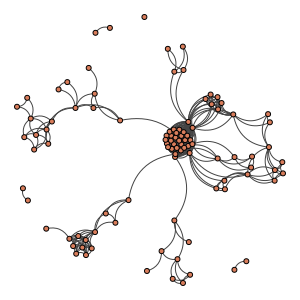

In [88]:
visual_style = {}

# Define colors used for gender visualization
colors = ['#4a3b90', '#d97d5b']
a.network.vs["color"] = [colors[0] if x == 'man' else colors[1] for x in a.network.vs['gender']]

# Set bbox and margin
visual_style["bbox"] = (300,300)
visual_style["margin"] = 17

# Set vertex size
visual_style["vertex_size"] = 5

# Set vertex lable size
visual_style["vertex_label_size"] = 8

# curve the edges
visual_style["edge_curved"] = True

# Plot the graph
igraph.plot(a.network, **visual_style)

In [91]:
# qualitative gender bias check, this should be mostly purple
a = Author(0.0,.5,.5,.5,'w')
a.init_network(g, node_2_gender, 100, 5)
print(a.network.summary())

IGRAPH UN-- 100 259 -- 
+ attr: gender (v), name (v)


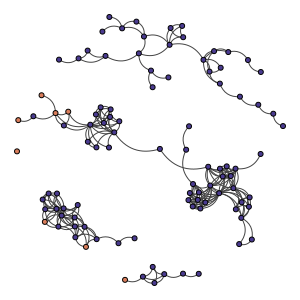

In [92]:
visual_style = {}

# Define colors used for gender visualization
colors = ['#4a3b90', '#d97d5b']
a.network.vs["color"] = [colors[0] if x == 'man' else colors[1] for x in a.network.vs['gender']]

# Set bbox and margin
visual_style["bbox"] = (300,300)
visual_style["margin"] = 17

# Set vertex size
visual_style["vertex_size"] = 5

# Set vertex lable size
visual_style["vertex_label_size"] = 8

# curve the edges
visual_style["edge_curved"] = True

# Plot the graph
igraph.plot(a.network, **visual_style)

In [93]:
# qualitative gender bias check, this should be mixed
a = Author(.5,.5,.5,.5,'w')
a.init_network(g, node_2_gender, 100, 5)
print(a.network.summary())

IGRAPH UN-- 100 192 -- 
+ attr: gender (v), name (v)


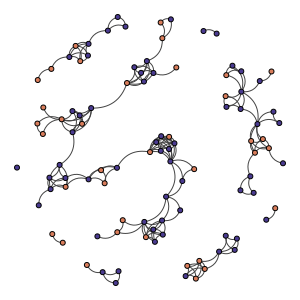

In [94]:
visual_style = {}

# Define colors used for gender visualization
colors = ['#4a3b90', '#d97d5b']
a.network.vs["color"] = [colors[0] if x == 'man' else colors[1] for x in a.network.vs['gender']]

# Set bbox and margin
visual_style["bbox"] = (300,300)
visual_style["margin"] = 17

# Set vertex size
visual_style["vertex_size"] = 5

# Set vertex lable size
visual_style["vertex_label_size"] = 8

# curve the edges
visual_style["edge_curved"] = True

# Plot the graph
igraph.plot(a.network, **visual_style)

#### Parameter sweeps

In [109]:
# gender proportion based on bias parameter
nSim = 50
net_biases = np.linspace(0.,1.,50)
n = 100

def test_gender_prop(b,nSim,g,node_2_gender,n):
    props = np.zeros((nSim,1))
    a = Author(b,.5,.5,.5,'w')
    for j in range(nSim):
        a.init_network(g, node_2_gender, n, 5)
        props[j,] = len(a.network.vs.select(gender='woman'))/n
    return props


genderProps = Parallel(n_jobs=4)(
    delayed(test_gender_prop)(b,nSim,g,node_2_gender,n)
    for b in tqdm(net_biases)
) 
    




  0%|          | 0/50 [00:00<?, ?it/s]


  8%|▊         | 4/50 [00:01<00:01, 31.80it/s]


  8%|▊         | 4/50 [00:18<00:01, 31.80it/s]


 16%|█▌        | 8/50 [01:54<11:47, 16.85s/it]


  0%|          | 0/50 [10:29<?, ?it/s]



 32%|███▏      | 16/50 [04:56<11:48, 20.85s/it]


 40%|████      | 20/50 [06:30<10:55, 21.85s/it]


 48%|████▊     | 24/50 [08:05<09:42, 22.42s/it]


 56%|█████▌    | 28/50 [09:37<08:18, 22.64s/it]


 64%|██████▍   | 32/50 [11:13<06:55, 23.09s/it]


 72%|███████▏  | 36/50 [12:47<05:24, 23.21s/it]


 80%|████████  | 40/50 [14:19<03:51, 23.13s/it]


 88%|████████▊ | 44/50 [15:53<02:19, 23.25s/it]


100%|██████████| 50/50 [17:23<00:00, 20.87s/it]


ValueError: probabilities contain NaN

In [110]:
plt.rcParams.update({'font.size': 25})        
plt.figure(figsize=(40,10))
plt.plot(net_biases, np.reshape(genderProps, (nSim, len(net_biases))), linewidth=3.0)
plt.ylabel('Proportion of woman:man in network')
plt.xlabel('Network Bias')

plt.grid(True)
plt.show()
plt.draw()

NameError: name 'genderProps' is not defined

<Figure size 2880x720 with 0 Axes>

In [107]:
# variability in edge numbers across instantitions
nSim = 50
net_biases = [0., .25, .5, .75, 1.]
n = 100

def test_edges(b,nSim,g,node_2_gender,n,d):
    props = np.zeros((nSim,1))
    a = Author(b,.5,.5,.5,'w')
    for j in range(nSim):
        a.init_network(g, node_2_gender, n, 7)
        props[j,] = len(a.network.es())
    return props

genderProps = Parallel(n_jobs=4)(
    delayed(test_edges)(b,nSim,g,node_2_gender,n,d)
    for b in tqdm(net_biases)
) 




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [01:36<06:24, 96.06s/it]

 40%|████      | 2/5 [02:38<03:49, 76.34s/it]

 60%|██████    | 3/5 [03:39<02:18, 69.42s/it]

 80%|████████  | 4/5 [04:41<01:06, 66.46s/it]<ipython-input-105-733078be752c>:121: RuntimeWarning: invalid value encountered in double_scalars
  transitionProb = [x/sum(transitionProb) for x in transitionProb]


ValueError: probabilities contain NaN

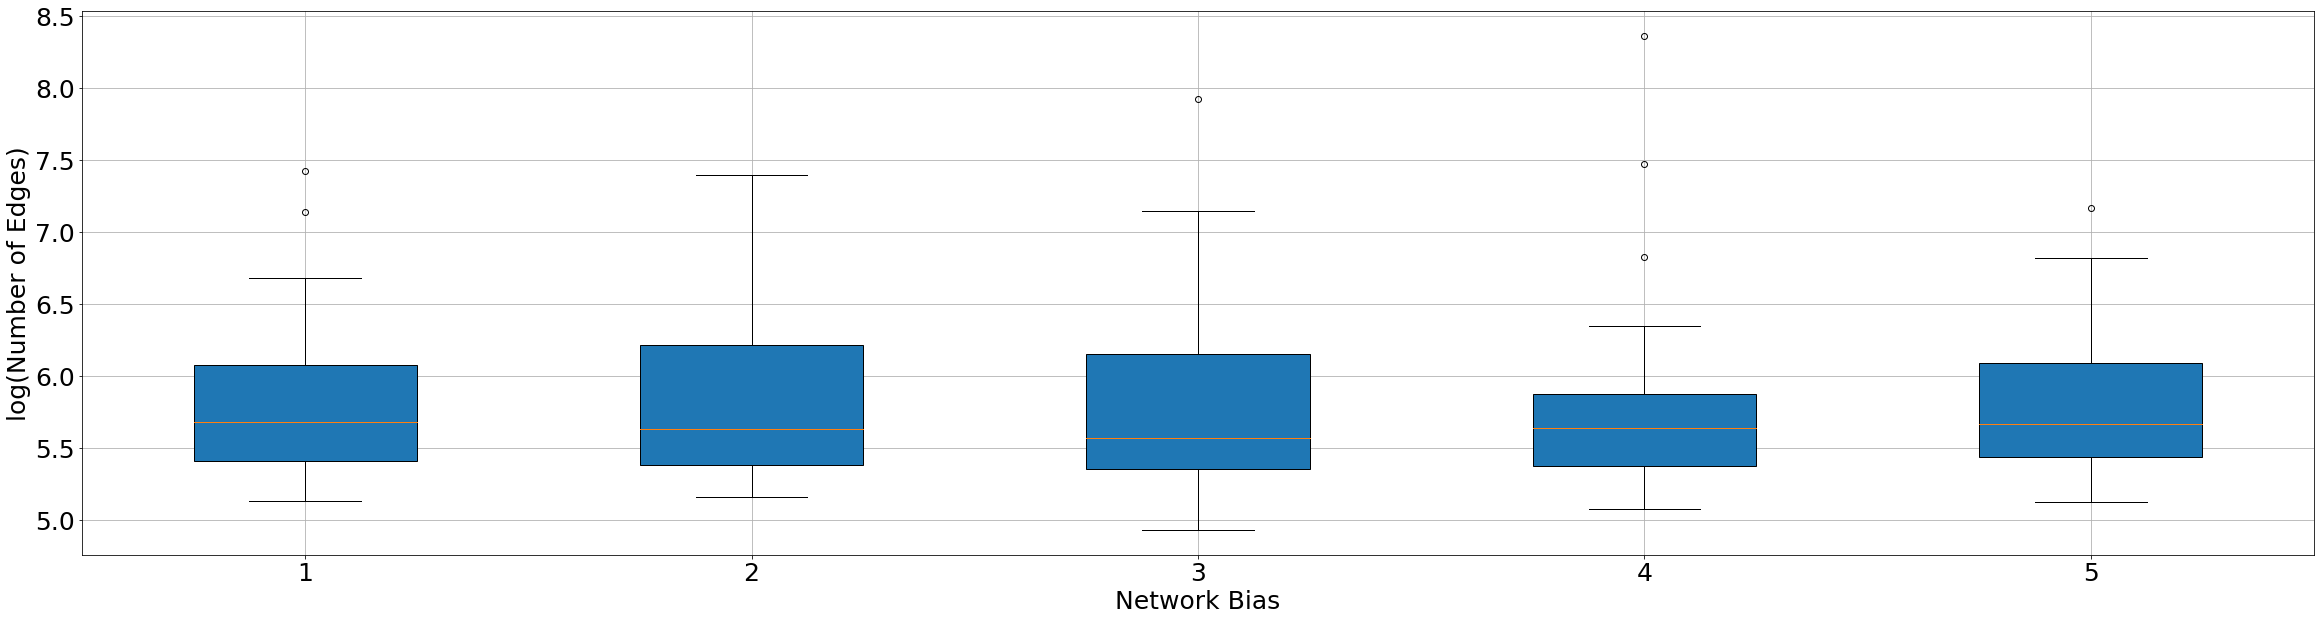

<Figure size 432x288 with 0 Axes>

In [26]:
plt.rcParams.update({'font.size': 25})        
plt.figure(figsize=(40,10))
plt.boxplot(np.reshape(np.log(edge_nums), (nSim, len(net_biases))),patch_artist=True)
plt.ylabel('log(Number of Edges)')
plt.xlabel('Network Bias')

plt.grid(True)
plt.show()
plt.draw()

In [50]:
# number of connected components per diameter and levy coeff


In [ ]:
# different network sizes


In [ ]:
# connected components for starting degree
